In [1]:
import os
import json
import wandb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

# set font to 12 and times new roman

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

sys.path.append('../')
from utils.data_utils import *

from utils.paths import EXPERIMENT_WANDB, SYNTHESIS_WANDB




In [2]:

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

Current working directory: /Users/nikolaushouben/Desktop/WattCast


In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [4]:


# Getting runs from experiments wandb project
api = wandb.Api()
runs = api.runs(EXPERIMENT_WANDB)

# starting up a run for synthesis in a different project
synthesis_run = wandb.init(project=SYNTHESIS_WANDB, name='results_synthesis')


## Results imports


### Grabbing all metrics from all runs from wandb

In [9]:
name_id_dict = get_run_name_id_dict(runs)

In [10]:
name_id_dict

{'3_village_village_2': '3_village_village_2_60min_aux_data--False',
 '3_village_village_1': '3_village_village_1_60min_aux_data--False',
 '3_village_village_0': '3_village_village_0_60min_aux_data--False',
 '4_neighborhood_neighborhood_2': '4_neighborhood_neighborhood_2_60min_aux_data--False',
 '4_neighborhood_neighborhood_1': '4_neighborhood_neighborhood_1_60min_aux_data--False',
 '4_neighborhood_neighborhood_0': '4_neighborhood_neighborhood_0_60min_aux_data--False',
 '5_building_building_2': '5_building_building_2_60min_aux_data--False',
 '5_building_building_1': '5_building_building_1_60min_aux_data--False',
 '2_town_town_2': '2_town_town_2_60min_aux_data--False',
 '2_town_town_1': '2_town_town_1_60min_aux_data--False',
 '2_town_town_0': '2_town_town_0_60min_aux_data--False',
 '1_county_Sacramento_60min': '1_county_Sacramento_60min_aux_data--False',
 '1_county_New_York': '1_county_New_York_60min_aux_data--False',
 '1_county_Los_Angeles': '1_county_Los_Angeles_60min_aux_data--False'

In [11]:
name_id_dict = {k:v for k,v in name_id_dict.items() if 'False' in v}

In [12]:
name_id_dict

{'3_village_village_2': '3_village_village_2_60min_aux_data--False',
 '3_village_village_1': '3_village_village_1_60min_aux_data--False',
 '3_village_village_0': '3_village_village_0_60min_aux_data--False',
 '4_neighborhood_neighborhood_2': '4_neighborhood_neighborhood_2_60min_aux_data--False',
 '4_neighborhood_neighborhood_1': '4_neighborhood_neighborhood_1_60min_aux_data--False',
 '4_neighborhood_neighborhood_0': '4_neighborhood_neighborhood_0_60min_aux_data--False',
 '5_building_building_2': '5_building_building_2_60min_aux_data--False',
 '5_building_building_1': '5_building_building_1_60min_aux_data--False',
 '2_town_town_2': '2_town_town_2_60min_aux_data--False',
 '2_town_town_1': '2_town_town_1_60min_aux_data--False',
 '2_town_town_0': '2_town_town_0_60min_aux_data--False',
 '1_county_Sacramento_60min': '1_county_Sacramento_60min_aux_data--False',
 '1_county_New_York': '1_county_New_York_60min_aux_data--False',
 '1_county_Los_Angeles': '1_county_Los_Angeles_60min_aux_data--False'

# Paper Figures & Tables

### Mappings for plotting shapes and colors

In [13]:
from utils.paths import RESULTS_DIR


model2shape = {
    'RandomForest': 'o',
    'LightGBMModel': 's',
    'XGBModel': 'D',
    'BlockRNNModel': 'x',
    'NBEATSModel': '^',
    'TFTModel': 'v',
    'LinearRegressionModel': '*',
    '48-Hour Persistence': 'P'
}


model2color = {
    'RandomForest': 'blue',
    'LightGBMModel': 'orange',
    'XGBModel': 'green',
    'BlockRNNModel': 'red',
    'NBEATSModel': 'purple',
    'TFTModel': 'pink',
    'LinearRegressionModel': 'brown',
    '48-Hour Persistence': 'black'
}


shape2model = {v: k for k, v in model2shape.items()}


metric_dict = {'mape': 'Mean Absolute Percentage Error (MAPE)',
               'rmse': 'Root Mean Squared Error (RMSE)',
                'mae': 'Mean Absolute Error (MAE)',
                'smape': 'Symmetric Mean Absolute Percentage Error (SMAPE)',
                'rmse_skill_score': 'RMSE Skill Score',
                'r2_score': 'R2 Score',
                'max_peak_error': 'Max Peak Error',
                'mean_n_peak_error': 'Mean N Peak Error',
                }

season2color = {'Summer': 'orange', 'Winter': 'blue'}
color2season = {v: k for k, v in season2color.items()}

horizon2color = {'Ground Truth': 'black',
                '1 Hours Ahead': 'blue',
                '4 Hours Ahead': 'green',
                '8 Hours Ahead': 'orange',
                '24 Hours Ahead': 'red',
                '48 Hours Ahead': 'purple'}


model_groups = {'Tree-based': ['RandomForest', 'LightGBMModel', 'XGBModel'],
                'Neural Network': ['BlockRNNModel', 'NBEATSModel', 'TFTModel'],
                'Benchmark': ['LinearRegressionModel', '48-Hour Persistence']}


model2group = {}
for group, models in model_groups.items():
    for model in models:
        model2group[model] = group


group2shape = {'Tree-based': 'x', 'Neural Network': 'o', 'Benchmark': 's'}
shape2group = {v: k for k, v in group2shape.items()}

group2color = {'Tree-based': 'blue', 'Neural Network': 'red', 'Benchmark': 'black'}
color2group = {v: k for k, v in group2color.items()}

In [17]:
dfs_sorted = {}
for name, run_id in name_id_dict.items():
    try:
        run_path = f'wattcast/{EXPERIMENT_WANDB}/run-{run_id}-Error metrics:latest'
        artifact = run.use_artifact(f'{run_path}', type='run_table')
        artifact_dir = artifact.download()
        with open(os.path.join(artifact_dir, os.listdir(artifact_dir)[0])) as f:
            data = json.load(f)
        df_metrics = pd.DataFrame(data['data'], columns=data['columns'])
        df = df_metrics.sort_values(by=['model', 'season'])
        dfs_sorted[name] = df
    except:
        print(f'Error in {name}')


Error in 3_village_village_2
Error in 3_village_village_1
Error in 3_village_village_0
Error in 4_neighborhood_neighborhood_2
Error in 4_neighborhood_neighborhood_1
Error in 4_neighborhood_neighborhood_0
Error in 5_building_building_2
Error in 5_building_building_1
Error in 2_town_town_2
Error in 2_town_town_1
Error in 2_town_town_0
Error in 1_county_Sacramento_60min
Error in 1_county_New_York
Error in 1_county_Los_Angeles


In [5]:
from utils.data_utils import get_hdf_keys
from utils.paths import CLEAN_DATA_DIR

get_hdf_keys(CLEAN_DATA_DIR)

({'5_building.h5': ['building_0', 'building_1', 'building_2'],
  '4_neighborhood.h5': ['neighborhood_0', 'neighborhood_1', 'neighborhood_2'],
  '3_village.h5': ['village_0', 'village_1', 'village_2'],
  '2_town.h5': ['town_0', 'town_1', 'town_2'],
  '1_county.h5': ['Los_Angeles', 'New_York', 'Sacramento']},
 {'5_building.h5': ['60min'],
  '4_neighborhood.h5': ['60min'],
  '3_village.h5': ['15min', '60min'],
  '2_town.h5': ['15min', '60min'],
  '1_county.h5': ['60min']})

In [29]:
name_id_dict

{'RAMAPO_XAgg': 'RAMAPO_XAgg.MWh_60min_aux_data--False',
 'GLENDOVEER_XAgg': 'GLENDOVEER_XAgg.MWh_60min_aux_data--False',
 'KELLY.BUTTE_XAgg': 'KELLY.BUTTE_XAgg.MWh_60min_aux_data--False',
 'LENTS_XAgg': 'LENTS_XAgg.MWh_60min_aux_data--False',
 'MIDWAY_XAgg': 'MIDWAY_XAgg.MWh_60min_aux_data--False'}

## Per Model

### Plot 1: Skill Score vs Horizon for each model and season

In [ ]:
# Set these:

spatial_scale = 'RAMAPO'
metric_of_interest = 'rmse_skill_score' # options are 'mape', 'rmse', 'mae', 'smape', 'rmse_skill_score', 'r2_score', 'max_peak_error', 'mean_n_peak_error'


dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]



fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)

    
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):
    # Map the colors and shapes to the DataFrame
    name, df = list(dfs_sorted_plot.items())[i]
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['model'].map(model2shape)

    # exclude 24 hour persistence
    df = df.loc[ df['model'] != '48-Hour Persistence']
    
    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]
            label = f'{shape2model[shape]} ({color2season[color]})'
            scatter = ax.scatter(x, y, c=color, marker=shape, label=label)
            if label not in legend_labels:
                legend_handles.append(scatter)
                legend_labels.append(label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{name.split("_")[1].split(".")[0]}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if metric_of_interest == 'rmse_skill_score':
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=True)
# Set the title for each subplot
fig.suptitle(f'{metric_dict[metric_of_interest]} Per Feeder in {spatial_scale}')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'{spatial_scale}{metric_of_interest}.{format}'), bbox_inches='tight')

### Plot 2: Side by side comparison of models for each season for a selected week

In [59]:
# set these
season = 'Summer'
algorithm = '48-Hour Persistence'

scale = "LENTS"
location = "XAgg"
unit = "MW"
conversion = 1

In [60]:
name_id_dict

{'RAMAPO_XAgg': 'RAMAPO_XAgg.MWh_60min_aux_data--False',
 'GLENDOVEER_XAgg': 'GLENDOVEER_XAgg.MWh_60min_aux_data--False',
 'KELLY.BUTTE_XAgg': 'KELLY.BUTTE_XAgg.MWh_60min_aux_data--False',
 'LENTS_XAgg': 'LENTS_XAgg.MWh_60min_aux_data--False',
 'MIDWAY_XAgg': 'MIDWAY_XAgg.MWh_60min_aux_data--False'}

In [61]:
files = get_file_names(project_name, name_id_dict, spatial_scale=scale, location=location,season= season)

side_by_side_plots_dict= download_plotly_plots(get_latest_plotly_plots(files))

df_all = side_by_side_df(side_by_side_plots_dict)

Plot

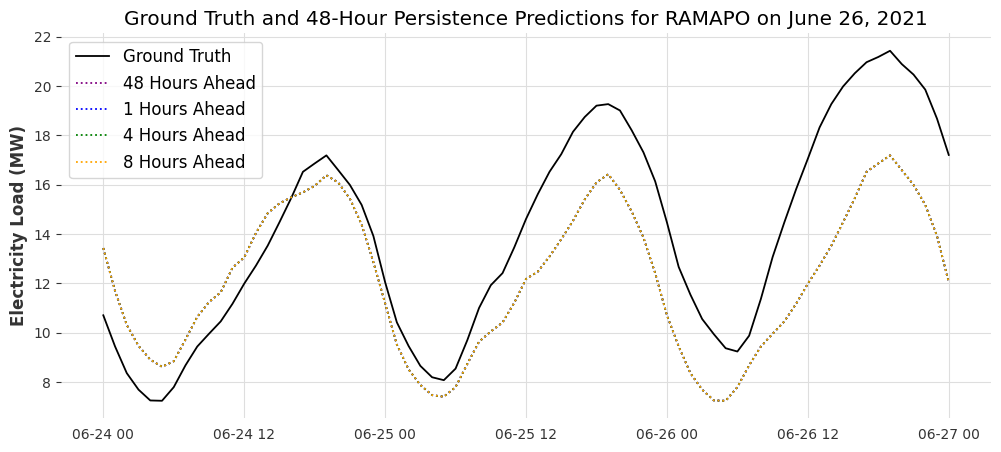

In [62]:
# find the day with the highest peak
dt_highest_peak = pd.Timestamp(df_all['Ground Truth'].idxmax()).date()
dt_start = dt_highest_peak - pd.Timedelta(days=2)
dt_end = dt_highest_peak + pd.Timedelta(days=2)

df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.loc[dt_start:dt_end]


fig, ax = plt.subplots(figsize=(12,5))

df_preds = df_all.filter(like=algorithm)
df_preds.columns = [col.split(':')[-1][1:] + ' Ahead' for col in df_preds.columns]
df_gt = df_all.filter(like='Ground')
df_plot = pd.concat([df_gt, df_preds], axis=1)
for col in df_plot.columns:
    ax.plot(df_plot[col], label=col, color=horizon2color[col], linestyle= 'solid' if col == 'Ground Truth' else ':')

ax.set_ylabel(f'Electricity Load ({unit})')
ax.set_title(f'Ground Truth and {algorithm} Predictions for {run_to_visualize.split("_")[0].split(".")[0]} on {dt_highest_peak.strftime("%B %d, %Y")}')

ax.grid(True, axis='x')
ax.legend(frameon=True)

In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'plot_3_side-by-side_horizons_heat_wave_{run_to_visualize}_{season}_{algorithm}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_3_side-by-side_horizons_heat_wave_{run_to_visualize}_{season}_{algorithm}': wandb.Image(fig)})

### Plot 3: Comparing Spatial Scales (mean of seasons and datasets)

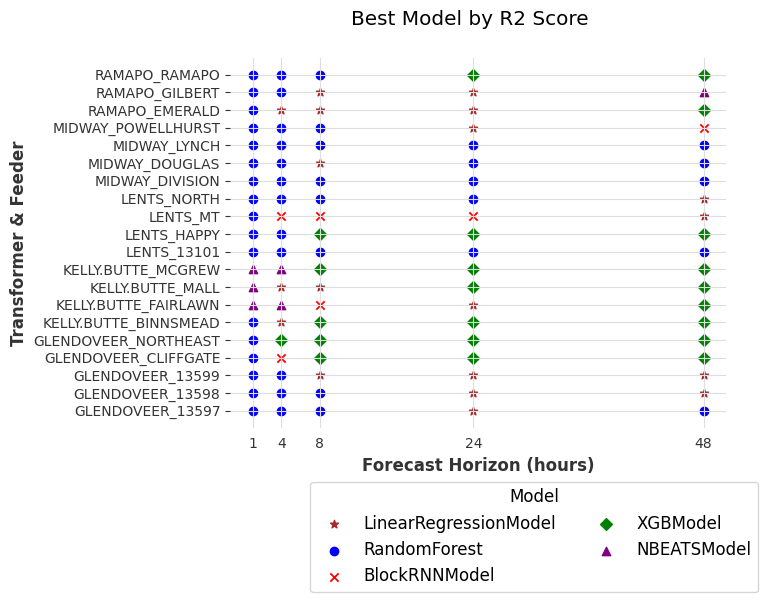

In [73]:
metric_of_interest = 'r2_score'

df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = scale.split('in')[0]
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

# marginalize over the season
df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

# extract the model with the best performance for each scale and horizon
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', metric_of_interest], ascending=False if metric_of_interest == 'rmse_skill_score' else True)
df_metrics_grouped = df_metrics_grouped.drop_duplicates(subset=['scale', 'horizon_in_hours'], keep='first')
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', 'horizon_in_hours'])
df_metrics_grouped = df_metrics_grouped.reset_index(drop=True)


# Define colors and shapes based on the season and model
df = df_metrics_grouped
fig, ax = plt.subplots()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []


# Map the colors and shapes to the DataFrame
df['shape'] = df['model'].map(model2shape)


for scale, df_scale in df.groupby('scale'): # this for loop is to make sure the order of scales is from county to neighborhood
    for shape in set(df_scale['shape']):
        x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
        y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
        label = f'{shape2model[shape]}'
        scatter = ax.scatter(x, y, marker=shape, label=label, color=model2color[shape2model[shape]])
        if label not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append(label)

# Set the x ticks and labels
ax.set_xticks([1, 4, 8, 24, 48])
ax.set_xlabel('Forecast Horizon (hours)')


ax.set_ylabel('Transformer & Feeder')

# Set the title for each subplot
fig.suptitle(f'Best Model by {metric_dict[metric_of_interest]}')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.6, -0.25), ncol=2, frameon=True)


# Show the plot
plt.show()


In [ ]:

for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'plot_1_overview_across_scales_{metric_of_interest}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_1_overview_across_scales_{metric_of_interest}': fig})

### Plot 4: Comparing Spatial Scales (mean of datasets per season)

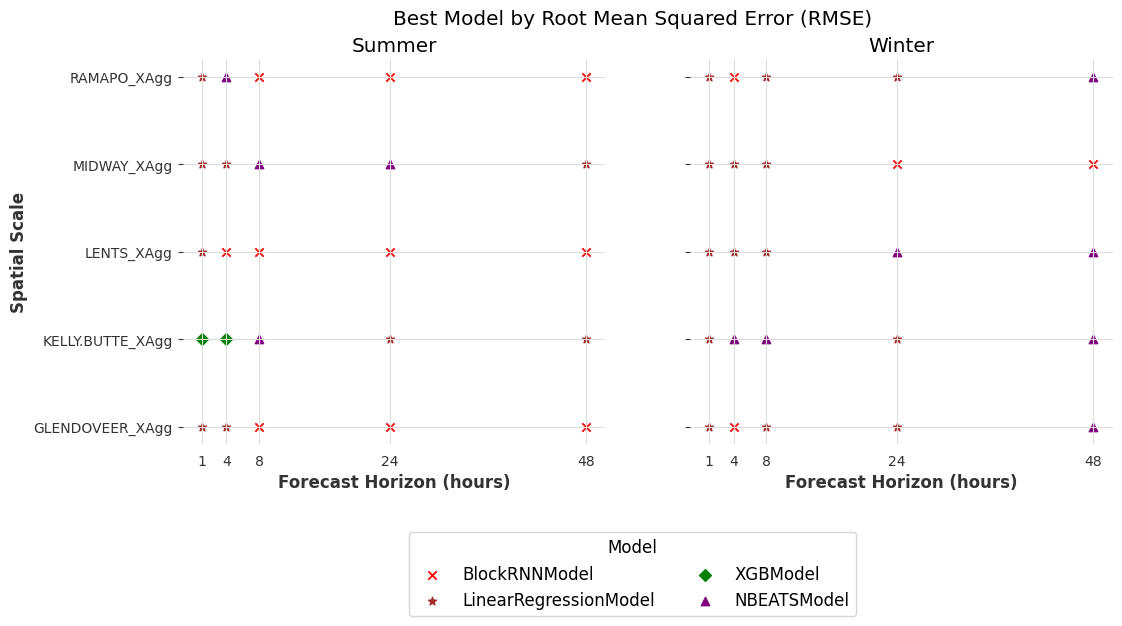

In [28]:
df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = scale.split('in')[0]
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

df_metrics_grouped = df_metrics_all_scales.groupby(['season', 'scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

season = 'Winter'

fig, axs = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

axs = axs.ravel()
# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):

    season = list(season2color.keys())[i]

    df_metrics_grouped_season = df_metrics_grouped.loc[df_metrics_grouped['season'] == season]

    df = get_best_model_per_scale_and_horizon(df_metrics_grouped_season, metric_of_interest)

    shape2model = {v: k for k, v in model2shape.items()}

    # Map the colors and shapes to the DataFrame
    df['shape'] = df['model'].map(model2shape)

    for scale, df_scale in df.groupby('scale'):
        for shape in set(df_scale['shape']):
            x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
            y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
            label = f'{shape2model[shape]}'
            scatter = ax.scatter(x, y, marker=shape, label=label, color=model2color[shape2model[shape]])
            if label not in legend_labels:
                legend_handles.append(scatter)
                legend_labels.append(label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (hours)')
    
    #ax.set_yticklabels(sorted(ax.get_yticklabels(), key=lambda x: x.get_text()))


    # Set the y label
    if i == 0:
        ax.set_ylabel('Spatial Scale')

    # Set the title for each subplot
    ax.set_title(f'{season}')


# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=True)

fig.suptitle(f'Best Model by {metric_dict[metric_of_interest]}')
# Adjust the spacing between subplots
#fig.tight_layout()

# Show the plot
plt.show()


## Tree-based models vs. Deep learning models

### Plot 1

AttributeError: 'Axes' object has no attribute 'ravel'

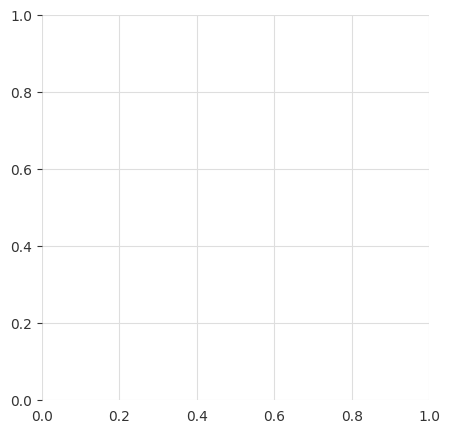

In [16]:
# Set these:

spatial_scale = 'GLENDOVEER'
metric_of_interest = 'rmse_skill_score'

dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]


# Define colors and shapes based on the season and model
color2season = {v: k for k, v in season2color.items()}
shape2model = {v: k for k, v in model2shape.items()}


fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):
    # Map the colors and shapes to the DataFrame
    name, df = list(dfs_sorted_plot.items())[i]
    # exclude 24 hour persistence
    df = df.loc[df['model'] != '48-Hour Persistence']
    df['group'] = df['model'].map(model2group)
    df = df.groupby(['group', 'horizon_in_hours', 'season']).mean().reset_index()
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['group'].map(group2shape)
    
    
    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]
            label = f'{shape2group[shape]} ({color2season[color]})'
            scatter = ax.scatter(x, y, c=color, marker=shape, label=label)
            if label not in legend_labels:
                legend_handles.append(scatter)
                legend_labels.append(label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{name.split("_")[1].split(".")[0]}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if metric_of_interest == 'rmse_skill_score':
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=True)
fig.suptitle(f'{metric_dict[metric_of_interest]} Per Feeder in {spatial_scale}')
# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


### Plot 3

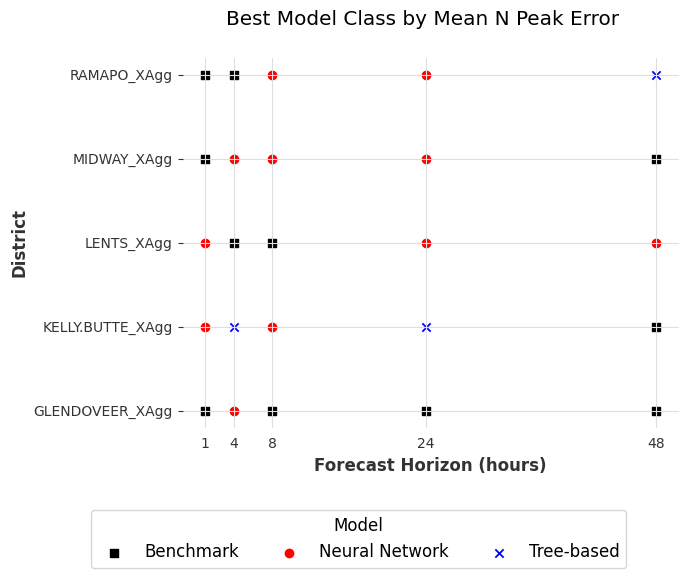

In [23]:
metric_of_interest = 'mean_n_peak_error' # options are 'mape', 'rmse', 'mae', 'smape', 'rmse_skill_score', 'r2_score', 'max_peak_error', 'mean_n_peak_error'

df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = scale.split('in')[0]
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

# marginalize over the season
df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

# extract the model with the best performance for each scale and horizon
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', metric_of_interest], ascending=False if metric_of_interest == 'rmse_skill_score' else True)
df_metrics_grouped = df_metrics_grouped.drop_duplicates(subset=['scale', 'horizon_in_hours'], keep='first')
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', 'horizon_in_hours'])
df_metrics_grouped = df_metrics_grouped.reset_index(drop=True)


# Define colors and shapes based on the season and model
df = df_metrics_grouped
shape2model = {v: k for k, v in model2shape.items()}

fig, ax = plt.subplots()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []


# Map the colors and shapes to the DataFrame
df['group'] = df['model'].map(model2group)
df = df.groupby(['group', 'horizon_in_hours', 'scale']).mean().reset_index()

df['shape'] = df['group'].map(group2shape)

for scale, df_scale in df.groupby('scale'): # this for loop is to make sure the order of scales is from county to neighborhood
    for shape in set(df_scale['shape']):
        x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
        y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
        label = f'{shape2group[shape]}'
        scatter = ax.scatter(x, y, marker=shape, label=label, color=group2color[shape2group[shape]])
        if label not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append(label)

# Set the x ticks and labels
ax.set_xticks([1, 4, 8, 24, 48])
ax.set_xlabel('Forecast Horizon (hours)')

ax.set_ylabel('District')

# Set the title for each subplot
fig.suptitle(f'Best Model Class by {metric_dict[metric_of_interest]}')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.4, -0.2), ncol=3, frameon=True)


# Show the plot
plt.show()


In [ ]:

for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'plot_1_overview_across_scales_{metric_of_interest}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_1_overview_across_scales_{metric_of_interest}': fig})

In [ ]:

import pickle
with open("../data/evaluations/GLENDOVEER/13599.pkl", "rb",) as f:
    dict_result_n_ahead = pickle.load(f)

eval_seaons = ['Winter', 'Summer']

evaluated_seasons = list(dict_result_n_ahead[1].keys())

eval_seasons_new = list(set(eval_seaons) - set(evaluated_seasons))

if len(eval_seasons_new) == 0:
    print("All seasons are evaluated")
    

eval_seasons_new